Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "JAEWON LEE"
COLLABORATORS = ""

---

# NLP Classification

In this assignment we look at several ways of classifying texts:
- Naive Bayes
- Logistic Regression
- Multinomial Regression

We also look at binary label classification problems (e.g., sentiment analysis) and multinomial classification problems (e.g., topic analysis).

We will use two datasets:
- [IMDb movie review sentiment](http://ai.stanford.edu/~amaas/data/sentiment/)
- [AG News topics](https://huggingface.co/datasets/ag_news)

**Tips:**
- Read all the code. We don't ask you to write the training loops, or evaluation loops, but it is often instructive to see how the models are trained and evaluated.
- If you have a model that is learning (loss is decreasing), but you want to increase accuracy, try using ``nn.Dropout`` layers just before the final linear layer to force the model to handle missing or unfamiliar data.

Import packages.

# Set up

In [2]:
import nltk
import numpy as np
import os
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import defaultdict
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

# This will allow visualization of the neural network structure
# !pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot

Check if GPU available.

In [3]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


# Functions for cleaning up raw texts and tokenizing the corpus

We perform text preprocessing that includes: removing HTML tags, making text lower case, stemming, and disposing of stopwords. 
In the end, we will split the entire dataset into training, validation and test sets.

In [4]:
# Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= [ps.stem(word) for word in text]
    return text

In [5]:
stopwords_english = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
print(stopwords_english)

#removing the stopwords
def remove_stopwords(text, stopword_list):
    tokens = [token.strip() for token in text]
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    return filtered_tokens

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [6]:
def tokenize_and_clean(line, stem_and_remove_stop_words = True):

    line = re.sub(r"<.*?>", "", line).strip() # remove all HTML tags 
    line = re.sub(r'[^a-zA-Z0-9]', ' ', line) # remove punc
    line = line.lower().split()  # lower case
    if stem_and_remove_stop_words:
        line = remove_stopwords(line, stopwords_english)
        line = simple_stemmer(line)

    return line

# Download and unpack the sentiment data



We are using IMDb Dataset for binary sentiment classification that provides a set of 25K highly polar reviews for training, and 25K for testing 
(each set contains an equal number of positive and negative examples). 

Dataset folder structure is as follows:

dataset/ \
├── test/ \
│     ├── pos/ \
│     ├── neg/ \
├── train/ \
      ├── pos/ \
      └── neg/ 

In [7]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!gunzip aclImdb_v1.tar.gz
!tar -xvf aclImdb_v1.tar

Load in the text from the folders.

In [8]:
def load_text_from_folders(path, file_list, dataset, samples = 1000, stem_and_remove_stop_words = True):
    """Read set of files from given directory and save returned lines to list.
    
    Parameters
    ----------
    path : str
        Absolute or relative path to given file (or set of files).
    file_list: list
        List of files names to read.
    dataset: list
        List that stores read lines.
    samples: int
        Number of samples in the output
    """
    for i, file in enumerate(file_list):
        if i >= samples:
            break
        with open(os.path.join(path, file), 'r', encoding='utf8') as text:
            contents = text.read()
            contents_tokenized = tokenize_and_clean(contents, stem_and_remove_stop_words=stem_and_remove_stop_words)
            dataset.append(contents_tokenized)

# Creating training and test sets

This creates four arrays: 


*   ```train_pos``` -- instances in the training set with positive sentiment labels
*   ```train_neg``` -- instances in the training set with negative sentiment labels
*   ```test_pos``` -- instances in the testing set with positive sentiment labels
*   ```test_neg``` -- instances in the testing set with negative sentiment labels





In [9]:
# Path to dataset location
path = 'aclImdb/'

# Create lists that will contain read lines
train_pos, train_neg, test_pos, test_neg = [], [], [], []

# Create a dictionary of paths and lists that store lines (key: value = path: list)
sets_dict = {'train/pos/': train_pos, 'train/neg/': train_neg,
             'test/pos/': test_pos, 'test/neg/': test_neg}

# Load the data
for dataset in sets_dict:
  file_list = [f for f in os.listdir(os.path.join(path, dataset)) if f.endswith('.txt')]
  load_text_from_folders(os.path.join(path, dataset), file_list, sets_dict[dataset])

Convert into Pandas dataframes. Pandas is a virtual spreadsheet with a programmatic API. A ```DataFrame``` is a spreadsheet. We will make a spreadsheet of training data and one for testing data and one with everything together.

In [10]:
# Concatenate training and testing examples into one dataset
TRAIN = pd.concat([pd.DataFrame({'review': train_pos, 'label':1}),
                     pd.DataFrame({'review': train_neg, 'label':0})],
                     axis=0, ignore_index=True)

TEST = pd.concat([pd.DataFrame({'review': test_pos, 'label':1}),
                    pd.DataFrame({'review': test_neg, 'label':0})],
                    axis=0, ignore_index=True)

ALL = pd.concat([TRAIN, TEST])

Look at the data. 

This is a summary of the data. We see that the data is balanced between labels

In [11]:
TRAIN.label.value_counts()

label
1    1000
0    1000
Name: count, dtype: int64

This is the first few rows of the training set:

In [12]:
TRAIN.head()

,review,label
0,"[bromwel, high, cartoon, comedi, ran, time, pr...",1
1,"[homeless, houseless, georg, carlin, state, is...",1
2,"[brilliant, act, lesley, ann, warren, best, dr...",1
3,"[easili, underr, film, inn, brook, cannon, sur...",1
4,"[typic, mel, brook, film, much, less, slapstic...",1


# Creating a vocabulary file 

Next, we have to build a vocabulary. This is effectively a look-up table where every unique word in your data set has a corresponding index (an integer).
We do this as our machine learning model cannot operate on strings, but only numbers. Each index is used to construct a one-hot vector for each word.

In [13]:
class Vocab:
    def __init__(self, name):
        self.name = name
        self._word2index = {}
        self._word2count = {}
        self._index2word = {}
        self._n_words = 0  

    def get_words(self):
      return list(self._word2count.keys())

    def num_words(self):
      return self._n_words

    def word2index(self, word):
      return self._word2index[word]

    def index2word(self, word):
      return self._index2word[word]

    def word2count(self, word):
      return self._word2count[word]

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

Make a vocab object.

In [14]:
VOCAB = Vocab("imdb")
VOCAB_SIZE = 1000
NUM_LABELS = 2

Load the first ```n``` frequent words in the vocabulary. Do this by sorting by frequency and then truncating.

In [15]:
# Get word frequency counts
word_freq_dict = {}   # key = word, value = frequency
for review in ALL['review']:
  for word in review:
    if word in word_freq_dict:
      word_freq_dict[word] += 1
    else:
      word_freq_dict[word] = 1

# Get a list of (word, freq) tuples sorted by frequency
kv_list = []  # list of word-freq tuples so can sort
for (k,v) in word_freq_dict.items():
  kv_list.append((k,v))
sorted_kv_list = sorted(kv_list, key=lambda x: x[1], reverse=True)

# Load top n words in to vocab object
for word, freq in sorted_kv_list[:VOCAB_SIZE]:
  VOCAB.add_word(word)

# Naive Bayes
Naive Bayes Algorithm is based on the Bayes Rule which describes the probability of an event, 
based on prior knowledge of conditions that might be related to the event.

According to Bayes theorem:


```Posterior = likelihood * proposition/evidence```

or

```P(A|B) = P(B|A) * P(A)/P(B)```


Using word presence as features, create an array of features for each review. Each review will thus be an array of size ```len(vocab)``` where each index in the array is a token number and the value in that position is whether the token is present in the review. There will be ```num_rows``` arrays, making a ```num_rows x len(vocab)``` 2D array.

This function creates a bag of words. It returns a vector where each element is a count of the words in the sentence corresponding to the word index.

In [16]:
def make_bow(sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64)
    for word in sentence:
        if word not in VOCAB.get_words():
            continue
        vec[VOCAB.word2index(word)] += 1
    return vec.view(1, -1)

Prepare data ```X_TRAIN``` is a 2D array of size ```num_reviews x vocab_size``` that contains training data. Each row will be a bag of words, except each index contains a 1 or 0 based on word presence in the example. Each row is a vector of features $\phi_1 ... \phi_{|V|}$ assumed to be independent, where $|V|$ is size of the vocabulary. We don't need to know what the features are, only whether they are present in each example in the training set.

```X_TEST``` is the same as above but containing testing data.

 

In [17]:
# Vectorize text reviews to numbers 
# Make empty vectors
X_TRAIN = np.zeros((len(TRAIN), VOCAB_SIZE))
X_TEST = np.zeros((len(TEST), VOCAB_SIZE))

# Load in frequency counts
for i, row in TRAIN.iterrows():
    X_TRAIN[i] = np.array(make_bow(row['review'])) > 0 # The > 0 converts to presence instead of counts

for i, row in TEST.iterrows():
    X_TEST[i] = np.array(make_bow(row['review'])) > 0 # The > 0 converts to presence instead of counts

# The labels
Y_TRAIN = np.array(TRAIN['label'])
Y_TEST = np.array(TEST['label'])

What you want to do is to compute probabilities over the training data and then apply those probabilities to the testing examples. Use the Bayes formula to compute $P_{\rm test}(L_{+}|\phi_{0:|V|})$ and $P_{\rm test}(L_{-}|\phi_{0:|V|})$ for each review. Classify examples based on whether one probability is higher than another. That is, $sign(P_{\rm test}(L_{+}|\phi_{0:|V|}) - P_{\rm test}(L_{-}|\phi_{0:|V|}))$ indicates a positive review when greater than 0 and a negative review when less than 0.

**Hint:** You do not need to implement any loops. Numpy indexing and slicing operations, along with built in functions like `.mean()`, `.sum()`, etc. will allow all operations to be performed on each row of the data in parallel. 

Step 1: Compute the positive label condition:
$P(L_{+}|\phi_{0:|V|}) = P(\phi_{0:|V|}|L_{+})P(L_{+}) / P(\phi_{0:|V|})$

In [18]:
def prob_pos_given_features(x_train, y_train):
  log_probs = np.array([0] * x_train.shape[1]) 
  # YOUR CODE HERE
  log_probs = np.log((x_train[y_train == 1].sum(axis=0) + 1) / (x_train[y_train == 1].sum() + x_train.shape[1]))
  
  return log_probs
  

Step 2: Compute the negative label condition:
$P(L_{-}|\phi_{0:|V|}) = P(\phi_{0:|V|}|L_{-})P(L_{-}) / P(\phi_{0:|V|})$

In [19]:
def prob_neg_given_features(x_train, y_train):
  log_probs = np.array([0] * x_train.shape[1]) 
  # YOUR CODE HERE
  log_probs = np.log((x_train[y_train == 0].sum(axis=0) + 1) / (x_train[y_train == 0].sum() + x_train.shape[1]))
  return log_probs

In [20]:
pos_probs = prob_pos_given_features(X_TRAIN, Y_TRAIN)
neg_probs = prob_neg_given_features(X_TRAIN, Y_TRAIN)

Step 3: Make a label prediction. Subtract (in log scale) the positive from the negative. If the result is greater than zero then it is a prediction of `+` label. If the result is less thn zero then we make a prediction of `-` label. 

In [21]:
def naive_bayes(x, pos_probs, neg_probs):
  label = 0
  # YOUR CODE HERE
  label = (x * pos_probs).sum() - (x * neg_probs).sum()
  if label > 0:
    label = 1
  else:
    label = 0
    
  return label

# Naive Bayes Test (20 Points)

In [22]:
def test_naive_bayes(x_train, y_train, x_test, y_test):
  # Get the positive and negative feature probabilities
  pos_probs = prob_pos_given_features(x_train, y_train)
  neg_probs = prob_neg_given_features(x_train, y_train)
  correct = 0 # How many tests are correct
  # Iterate through the test set
  for x, y in zip(x_test, y_test):
    # Get the naive_bayes label
    label = naive_bayes(x, pos_probs, neg_probs)
    # Compare the label against the true label
    correct = correct + int(label == y)
  return correct / x_test.shape[0]

In [23]:
# student check - accuracies >= 80% will receive full credit (no credit for less than 80%)
test_naive_bayes(X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

0.8525

In [24]:
''' Hidden auto-grader test - do not delete this cell '''

' Hidden auto-grader test - do not delete this cell '

# Logistic Regression - Part 1

We will be using a neural network to perform logistic regression. We will use word counts as the input feature vector.


Reload the data, but use word counts instead of word presence.

In [25]:
# Randomize the data
TRAIN = TRAIN.sample(frac=1).reset_index(drop=True)
TEST = TEST.sample(frac=1).reset_index(drop=True)

# Vectorize text reviews to numbers
X_TRAIN = np.zeros((len(TRAIN), VOCAB_SIZE))
X_TEST = np.zeros((len(TEST), VOCAB_SIZE))

for i, row in TRAIN.iterrows():
  X_TRAIN[i] = np.array(make_bow(row['review']))

for i, row in TEST.iterrows():
  X_TEST[i] = np.array(make_bow(row['review']))

Y_TRAIN = np.array(TRAIN['label'])
Y_TEST = np.array(TEST['label'])

Make a logistic classifier torch neural network.

Complete the constructor and forward function. The net will take an arbitrary number of outputs, but for binary logistic regression, only one is needed because the single output neuron can take a value that is between 0 and 1, with 0 meaning negative sentiment and 1 meaning positive sentiment. There should only be as many parameters as ```num_features x (num_labels-1)``` in binary logistic regression and ```num_features x num_labels``` for multinomial logistic regression.

The input will be a one-hot vector of size `vocab_size`.

In [26]:
# Defining neural network structure
class BoWClassifier(nn.Module):  # inheriting from nn.Module!

  def __init__(self, num_labels, vocab_size):
    super(BoWClassifier, self).__init__()

    # YOUR CODE HERE
    self.linear = nn.Linear(vocab_size, num_labels)

  def forward(self, bow_vec): 
    # YOUR CODE HERE
    logits=self.linear(bow_vec)
    out = torch.sigmoid(logits)

    return out

Make the model, move it to the GPU.

In [27]:
# Initialize the model
# Use one label because the head can signify a 1 or 0 because of the sigmoid. 
bow_nn_model = BoWClassifier(NUM_LABELS-1, VOCAB_SIZE)
bow_nn_model.to(device)

BoWClassifier(
  (linear): Linear(in_features=1000, out_features=1, bias=True)
)

This function should return two tensors. The first, containing training data, shoud be of size ```batch_size x vocab_size``` for the ```i```th batch. The second should be a list of labels of size ```batch_size```. Both tensors should be of type ```dtype=torch.float```.

In [28]:
def get_batch(i, batch_size, x_data, y_data):
  # Make some empty tensors
  x = torch.zeros([batch_size, x_data.shape[1]])
  y = torch.zeros([batch_size, 1]) 
  # YOUR CODE HERE
  x = torch.tensor(x_data[i:i+batch_size,:], dtype=torch.float)
  y = torch.tensor(y_data[i:i+batch_size], dtype=torch.float)
  
  return x, y

# Logistic Regression - Part 1 Test (20 Points)

In [29]:
''' Hidden auto-grader test - do not delete this cell '''

' Hidden auto-grader test - do not delete this cell '

In [30]:
# student check
batch_index = 0
batch_size = 1000
x, y = get_batch(batch_index, batch_size, X_TRAIN, Y_TRAIN)
print(x.shape)
print(y.shape)

torch.Size([1000, 1000])
torch.Size([1000])


In [31]:
''' Hidden auto-grader test - do not delete this cell '''

' Hidden auto-grader test - do not delete this cell '

In [32]:
# student check - your model must have the expected number of layers to receive full credit, no credit otherwise
if len(list(bow_nn_model.children())) != 1:
  print("Model does not have the expected number of layers.")
else:
  print("Your model has one layer as expected!")


Your model has one layer as expected!


In [33]:
''' Hidden auto-grader test - do not delete this cell '''

' Hidden auto-grader test - do not delete this cell '

Forward pass output shape looks good!


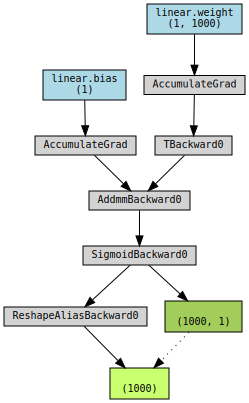

In [34]:
# student check
y_hat = bow_nn_model(x.to(device))
y_hat = y_hat.reshape(-1)

''' Hidden auto-grader test - do not delete this cell '''
if y_hat.shape[0] == batch_size:
  print("Forward pass output shape looks good!")
else:
  print("Seems to be an issue with output shape in your model...")
make_dot(y_hat, dict(bow_nn_model.named_parameters()))

# Logistic Regression - Part 2

Create a dataset as an array of (X_train, label).

Complete ```get_batch(i)``` and set ```batch_size``` and ```num_epochs```.

Training loop will call ```get_batch()``` with the iteration number and do everything else.


In [35]:
# Train the model
def train(model, train_data, test_data, epochs, batch_size):
  n_iter = len(train_data) // batch_size
  print(n_iter, 'batches per epoch')
  # Loss Function
  loss_function = nn.BCELoss()
  # Optimizer initlialization
  optimizer = optim.SGD(bow_nn_model.parameters(), lr=0.1)

  for epoch in range(epochs):
    # Make BOW vector for input features and target label
    for i in range(n_iter):
      x, y = get_batch(i, batch_size, train_data, test_data)

      # Step 3. Run the forward pass.
      y_hat = model(x.to(device))
      y_hat = y_hat.reshape(-1)

      # Step 4. Compute the loss, gradients, and update the parameters by
      loss = loss_function(y_hat,y.to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
      if (epoch+1)%10 == 0 and (i+1) == n_iter:
        print('epoch:', epoch+1,',loss =',loss.item(), ', training accuracy =',(torch.round(y_hat)==y.to(device)).float().mean())
  return model

In [36]:
# It's ok to modify this cell.
BATCH_SIZE = 1000
N_EPOCHS = 2000

In [37]:
bow_nn_model = train(bow_nn_model, X_TRAIN, Y_TRAIN, N_EPOCHS, BATCH_SIZE)

2 batches per epoch
epoch: 10 ,loss = 0.5439162850379944 , training accuracy = tensor(0.8180)
epoch: 20 ,loss = 0.46669602394104004 , training accuracy = tensor(0.8670)
epoch: 30 ,loss = 0.41843506693840027 , training accuracy = tensor(0.8890)
epoch: 40 ,loss = 0.3839007019996643 , training accuracy = tensor(0.9010)
epoch: 50 ,loss = 0.3572941720485687 , training accuracy = tensor(0.9050)
epoch: 60 ,loss = 0.3358120918273926 , training accuracy = tensor(0.9100)
epoch: 70 ,loss = 0.3178950846195221 , training accuracy = tensor(0.9160)
epoch: 80 ,loss = 0.30259114503860474 , training accuracy = tensor(0.9230)
epoch: 90 ,loss = 0.2892790138721466 , training accuracy = tensor(0.9320)
epoch: 100 ,loss = 0.27753227949142456 , training accuracy = tensor(0.9380)
epoch: 110 ,loss = 0.2670460641384125 , training accuracy = tensor(0.9450)
epoch: 120 ,loss = 0.2575954496860504 , training accuracy = tensor(0.9470)
epoch: 130 ,loss = 0.24900978803634644 , training accuracy = tensor(0.9490)
epoch: 14

epoch: 350 ,loss = 0.15300816297531128 , training accuracy = tensor(0.9780)
epoch: 360 ,loss = 0.15059643983840942 , training accuracy = tensor(0.9780)
epoch: 370 ,loss = 0.14826974272727966 , training accuracy = tensor(0.9790)
epoch: 380 ,loss = 0.14602316915988922 , training accuracy = tensor(0.9790)
epoch: 390 ,loss = 0.14385224878787994 , training accuracy = tensor(0.9800)
epoch: 400 ,loss = 0.14175280928611755 , training accuracy = tensor(0.9800)
epoch: 410 ,loss = 0.13972100615501404 , training accuracy = tensor(0.9800)
epoch: 420 ,loss = 0.13775330781936646 , training accuracy = tensor(0.9810)
epoch: 430 ,loss = 0.13584642112255096 , training accuracy = tensor(0.9820)
epoch: 440 ,loss = 0.13399729132652283 , training accuracy = tensor(0.9820)
epoch: 450 ,loss = 0.1322030872106552 , training accuracy = tensor(0.9820)
epoch: 460 ,loss = 0.1304611712694168 , training accuracy = tensor(0.9820)
epoch: 470 ,loss = 0.12876906991004944 , training accuracy = tensor(0.9830)
epoch: 480 ,lo

# Logistic Regression - Part 2 Test (20 Points)

In [38]:
from sklearn.metrics import classification_report

bow_nn_predictions = []

with torch.no_grad():
    for index, row in TEST.iterrows():
        bow_vec = make_bow(row['review'])
        probs = bow_nn_model(bow_vec.float().to(device))
        pred = 1 if probs[0][0] > 0.5 else 0
        bow_nn_predictions.append(pred)

In [39]:
# student check - accuracies >= 80% will receive full credit (no credit for less than 80%)
print(classification_report(TEST['label'],bow_nn_predictions))
(bow_nn_predictions==TEST['label']).mean() 

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.80      0.82      0.81      1000

    accuracy                           0.81      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.81      0.81      0.80      2000



0.805

In [40]:
''' Hidden auto-grader test - do not delete this cell '''

' Hidden auto-grader test - do not delete this cell '

# Multinomial Regression

Load data.

In [41]:
!pip install datasets

In [42]:
import datasets 
from datasets import load_dataset

c:\Users\jaewo\anaconda3\envs\assign-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unlike earlier, we will use a pre-defined set of embeddings, called [GLoVe](https://nlp.stanford.edu/projects/glove/). GLoVe replaces every word with a 100-dimensional vector of floating point values. The advantage of this is that words with similar semantic meanings will have similar vectors. This is important because the vocabulary size of the corpus we will use is 400,000.

For the assigment, instead of getting a one-hot vector for each word, the neural network will get a `batch_size x num_words x 100` tensor containing floating point values.

Download the GLoVe embedding vectors.

In [43]:
import gensim
import gensim.downloader

In [44]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')
VOCAB_SIZE = len(glove_vectors.vectors)
EMBEDDING_DIM = 100

This function will embed the dataset into sequences of 100-dimension vectors.

In [45]:
# pad dataset to a maximum review length in words
MAX_LEN = 50

def get_glove_seq(review, max_len):
  seq = np.zeros((max_len, 100))
  for i, word in enumerate(review):
    if i < max_len and word in glove_vectors:
      seq[i] = glove_vectors[word]
  return seq

In [46]:
news_data_train = load_dataset("ag_news", split="train").shuffle()
news_data_test = load_dataset("ag_news", split="test").shuffle()
NEWS_TRAIN = pd.DataFrame(news_data_train)[:5000]
NEWS_TEST = pd.DataFrame(news_data_test)[:5000]
NUM_LABELS = 4

In [47]:
NEWS_TEST.head()

,text,label
0,"Lacie announces external SATA harddrive, high-...",3
1,Palestinians Sift Rubble After Israel's Gaza A...,0
2,Microsoft issues patches for 7 software flaws ...,3
3,Bobcats Trade Drobnjak to Hawks for Pick (AP) ...,1
4,Dover #39;s place in #39;Chase #39; looks sec...,1


Train/Test Sets using GloVe embeddings.

In [48]:
# Vectorize text reviews to numbers
X_NEWS_TRAIN = np.zeros((len(NEWS_TRAIN), MAX_LEN, 100))
X_NEWS_TEST = np.zeros((len(NEWS_TEST), MAX_LEN, 100))

for i, row in NEWS_TRAIN.iterrows():
  X_NEWS_TRAIN[i] = get_glove_seq(tokenize_and_clean(row['text'], stem_and_remove_stop_words=False), MAX_LEN)

for i, row in NEWS_TEST.iterrows():
  X_NEWS_TEST[i] = get_glove_seq(tokenize_and_clean(row['text'], stem_and_remove_stop_words=False), MAX_LEN)

Y_NEWS_TRAIN = np.array(NEWS_TRAIN['label'])
Y_NEWS_TEST = np.array(NEWS_TEST['label'])
NUM_LABELS = 4

In [49]:
# Defining neural network structure
class MultinomialBoWClassifier(nn.Module):  # inheriting from nn.Module!
  def __init__(self, max_word_len, embedding_dim, num_labels):
    super(MultinomialBoWClassifier, self).__init__()
    self.max_word_len = max_word_len
    self.embedding_dim = embedding_dim
    self.num_labels = num_labels
    # YOUR CODE HERE
    self.linear = nn.Linear(max_word_len * embedding_dim, num_labels)


  def forward(self, x): 
    out = None
    # YOUR CODE HERE
    x = x.view(-1, self.max_word_len * self.embedding_dim)
    out = self.linear(x)

    return out

In [50]:
multibow_model = MultinomialBoWClassifier(max_word_len=MAX_LEN, embedding_dim=EMBEDDING_DIM, num_labels=NUM_LABELS)
multibow_model.to(device)


MultinomialBoWClassifier(
  (linear): Linear(in_features=5000, out_features=4, bias=True)
)

In [51]:
# It's ok to modify this cell.

# 0.7605
# BATCH_SIZE = 50
# N_EPOCHS = 100
# LEARNING_RATE = 5e-4
# WEIGHT_DECAY = 1e-4

# 0.795
BATCH_SIZE = 10
N_EPOCHS = 100
LEARNING_RATE = 6e-4
WEIGHT_DECAY = 1e-4

# 0.7174 
# BATCH_SIZE = 50
# N_EPOCHS = 100
# LEARNING_RATE = 5e-3
# WEIGHT_DECAY = 1e-2

In [52]:
# Train the model
def train(model, x_train_data, y_train_data, epochs, batch_size, lr, weight_decay):
  print('Training Started!')
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  criterion = nn.CrossEntropyLoss()
  n_iter = len(x_train_data) // batch_size
  print(n_iter, 'batches per epoch')

  for epoch in range(epochs):
    num_correct = 0
    total_loss = 0.0
    model.train()

    for i in range(n_iter):
      x, y = get_batch(i, batch_size, x_train_data, y_train_data)
      x = x.to(device)
      y = y.long().to(device)

      y_hat = model(x)
      loss = criterion(y_hat, y)
      total_loss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (epoch+1)%10 == 0 and (i+1) == n_iter:
        print('epoch:', epoch+1,',loss =',loss.item(), ', training accuracy =',(y_hat.argmax(dim=1)==y).float().mean().item())

In [53]:
train(multibow_model, X_NEWS_TRAIN, Y_NEWS_TRAIN, N_EPOCHS, BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

Training Started!
500 batches per epoch


epoch: 10 ,loss = 0.0011953325010836124 , training accuracy = 1.0
epoch: 20 ,loss = 0.000563891779165715 , training accuracy = 1.0
epoch: 30 ,loss = 0.0003528358938638121 , training accuracy = 1.0
epoch: 40 ,loss = 0.0003203710657544434 , training accuracy = 1.0
epoch: 50 ,loss = 0.00022535216703545302 , training accuracy = 1.0
epoch: 60 ,loss = 0.0004405081272125244 , training accuracy = 1.0
epoch: 70 ,loss = 0.00028884364292025566 , training accuracy = 1.0
epoch: 80 ,loss = 0.0006320413085632026 , training accuracy = 1.0
epoch: 90 ,loss = 0.0003375050437171012 , training accuracy = 1.0
epoch: 100 ,loss = 0.0004328397917561233 , training accuracy = 1.0


# Multinomial Regression - Test (40 Points)

In [54]:
multibow_model.eval()

with torch.no_grad():
    text_vec = torch.tensor(X_NEWS_TEST, dtype=torch.float, device=device)
    probs = multibow_model(text_vec)
    pred = probs.argmax(dim=1)

targets = torch.tensor(Y_NEWS_TEST, device=device)

In [55]:
# student check - accuracies >= 80% will receive full credit (no credit for less than 80%)
(pred==targets).float().mean().item()

0.8022000193595886

In [56]:
''' Hidden auto-grader test - do not delete this cell '''

' Hidden auto-grader test - do not delete this cell '

# Grading

Please submit this .ipynb file to Canvas for grading.